In [1]:
import os
import cv2
import torch
import random
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn.functional as F  # For PyTorch functional operations like relu
import torchvision.transforms.functional as TF  # For transformations like vflip, hflip
import matplotlib.pyplot as plt
from torchvision import models

################################################################################
# Model Definitions
################################################################################

import torch.nn as nn

class VGG16Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        # Load VGG16 with pretrained weights
        vgg16 = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
        features = vgg16.features  # nn.Sequential of conv/pool layers

        # Modify the first Conv2d to take 4 channels (RGB + Trimap)
        old_conv0 = features[0]  # conv2d(3,64, kernel_size=3, padding=1)
        new_conv0 = nn.Conv2d(4, 64, kernel_size=3, padding=1)
        with torch.no_grad():
            new_conv0.weight[:, :3] = old_conv0.weight
            new_conv0.weight[:, 3] = 0.0  # Initialize the 4th channel to zero
            new_conv0.bias[:] = old_conv0.bias
        features[0] = new_conv0

        # Split VGG16 into four blocks
        self.block1 = features[0:5]    # conv1_x + pool => output 1/2
        self.block2 = features[5:10]   # conv2_x + pool => output 1/4
        self.block3 = features[10:17]  # conv3_x + pool => output 1/8
        self.block4 = features[17:24]  # conv4_x + pool => output 1/16

        # fc6-as-conv + extra conv (keeping the same dimension)
        self.fc6_conv = nn.Conv2d(in_channels=512, out_channels=512,
                                  kernel_size=3, padding=1)
        nn.init.xavier_normal_(self.fc6_conv.weight)

        self.fc7_conv = nn.Conv2d(in_channels=512, out_channels=512,
                                  kernel_size=3, padding=1)
        nn.init.xavier_normal_(self.fc7_conv.weight)

    def forward(self, x):
        """
        x: [B,4,H,W]  (RGB + Trimap)
        Returns:
          bottom:  [B,512, H/16, W/16] after block4 + fc6 + fc7
          skips: [skip1, skip2, skip3]
                  skip1 => [B,64,  H/2,  W/2]
                  skip2 => [B,128, H/4,  W/4]
                  skip3 => [B,256, H/8,  W/8]
        """
        # Block1 => 1/2 scale
        x = self.block1(x)
        skip1 = x  # [B,64, H/2, W/2]

        # Block2 => 1/4 scale
        x = self.block2(x)
        skip2 = x  # [B,128, H/4, W/4]

        # Block3 => 1/8 scale
        x = self.block3(x)
        skip3 = x  # [B,256, H/8, W/8]

        # Block4 => 1/16 scale
        x = self.block4(x)  # [B,512, H/16, W/16]

        # fc6-as-conv + extra
        x = self.fc6_conv(x)
        x = F.relu(x, inplace=True)
        x = self.fc7_conv(x)
        x = F.relu(x, inplace=True)

        return x, [skip1, skip2, skip3]

class DecoderBlock(nn.Module):
    """
    A simple "cat->conv->conv->conv->relu" block, for after we upsample.
    """
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(out_ch)
        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(out_ch)
        self.conv3 = nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1)
        self.bn3   = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.relu(self.bn3(self.conv3(x)))
        return x

class MattingDecoder(nn.Module):
    """
    Decode from bottom feature (1/16 scale) back to full res 1× size.
    """
    def __init__(self):
        super().__init__()
        # After block4+fc6, we have [B,512,H/16,W/16].
        # skip3 => [B,256,H/8,W/8]
        # skip2 => [B,128,H/4,W/4]
        # skip1 => [B, 64,H/2,W/2]

        self.dec3 = DecoderBlock(in_ch=512+256, out_ch=256)
        self.dec2 = DecoderBlock(in_ch=256+128, out_ch=128)
        self.dec1 = DecoderBlock(in_ch=128+64, out_ch=64)

        self.final_conv = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, bottom, skips):
        skip1, skip2, skip3 = skips

        x = F.interpolate(bottom, scale_factor=2, mode='bilinear', align_corners=True)
        x = torch.cat([x, skip3], dim=1)
        x = self.dec3(x)

        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
        x = torch.cat([x, skip2], dim=1)
        x = self.dec2(x)

        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
        x = torch.cat([x, skip1], dim=1)
        x = self.dec1(x)

        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
        alpha = self.final_conv(x)
        alpha = torch.sigmoid(alpha)
        return alpha

class Stage1MattingNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = VGG16Encoder()
        self.decoder = MattingDecoder()

    def forward(self, x):
        bottom, skips = self.encoder(x)
        alpha = self.decoder(bottom, skips)
        return alpha

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(channels)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(channels)
        self.relu  = nn.ReLU(inplace=True)

    def forward(self, x):
        skip = x
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        x = x + skip
        x = self.relu(x)
        return x

class RefinementNet(nn.Module):
    """
    Takes [B,4,H,W] = (3-channel RGB + 1-channel raw alpha),
    outputs refined alpha of shape [B,1,H,W].
    """
    def __init__(self, in_ch=4, mid_ch=64):
        super().__init__()
        self.head = nn.Conv2d(in_ch, mid_ch, kernel_size=3, padding=1)
        self.bn_head = nn.BatchNorm2d(mid_ch)
        self.res1 = ResidualBlock(mid_ch)
        self.res2 = ResidualBlock(mid_ch)
        self.res3 = ResidualBlock(mid_ch)
        self.res4 = ResidualBlock(mid_ch)  # Extra block
        self.final_conv = nn.Conv2d(mid_ch, 1, kernel_size=1)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.relu(self.bn_head(self.head(x)))
        x = self.res1(x)
        x = self.res2(x)
        x = self.res3(x)
        x = self.res4(x)
        out_alpha = self.final_conv(x)
        out_alpha = torch.sigmoid(out_alpha)
        return out_alpha

class TwoStageMattingNet(nn.Module):
    """
    - Stage1: UNet (VGG16) => raw_alpha
    - Stage2: refine => refined_alpha
    """
    def __init__(self):
        super().__init__()
        self.stage1 = Stage1MattingNet()
        self.stage2 = RefinementNet()

    def forward(self, rgb, trimap):
        x_stage1 = torch.cat([rgb, trimap], dim=1)
        raw_alpha = self.stage1(x_stage1)

        x_stage2 = torch.cat([rgb, raw_alpha], dim=1)
        refined_alpha = self.stage2(x_stage2)

        return raw_alpha, refined_alpha

################################################################################
# Dataset and DataLoader
################################################################################

DATASET_PATH = "/kaggle/input/alpha-matte-dataset/"
GT_DIR = os.path.join(DATASET_PATH, "gt_training_lowres")
INPUT_DIR = os.path.join(DATASET_PATH, "input_training_lowres")
TRIMAP_DIR = os.path.join(DATASET_PATH, "trimap_training_lowres/Trimap1")

IMG_SIZE = (800,800)

class AlphaMatteDataset(Dataset):
    def __init__(self, input_dir, trimap_dir, gt_dir, transform=None):
        self.input_dir = input_dir
        self.trimap_dir = trimap_dir
        self.gt_dir = gt_dir
        self.input_files = sorted(os.listdir(input_dir))
        self.transform = transform

    def __len__(self):
        return len(self.input_files)

    def __getitem__(self, idx):
        input_path = os.path.join(self.input_dir, self.input_files[idx])
        trimap_path = os.path.join(self.trimap_dir, self.input_files[idx])
        gt_path = os.path.join(self.gt_dir, self.input_files[idx])

        input_image = cv2.imread(input_path, cv2.IMREAD_COLOR)
        trimap = cv2.imread(trimap_path, cv2.IMREAD_GRAYSCALE)
        gt = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)

        input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)

        input_image = cv2.resize(input_image, IMG_SIZE, interpolation=cv2.INTER_AREA)
        trimap = cv2.resize(trimap, IMG_SIZE, interpolation=cv2.INTER_NEAREST)
        gt = cv2.resize(gt, IMG_SIZE, interpolation=cv2.INTER_AREA)

        trimap = trimap / 255.0
        gt = gt / 255.0

        input_image = transforms.ToTensor()(input_image)
        trimap = torch.from_numpy(trimap).unsqueeze(0).float()
        gt = torch.from_numpy(gt).unsqueeze(0).float()

        if self.transform:
            input_image, trimap, gt = self.transform(input_image, trimap, gt)

        return input_image, trimap, gt

################################################################################
# Transformations (Augmentations)
################################################################################

def random_transform(input_image, trimap, gt):
    if random.random() > 0.5:
        input_image = TF.hflip(input_image)
        trimap = TF.hflip(trimap)
        gt = TF.hflip(gt)

    if random.random() > 0.5:
        input_image = TF.vflip(input_image)
        trimap = TF.vflip(trimap)
        gt = TF.vflip(gt)

    angle = random.choice([0, 90, 180, 270])
    if angle != 0:
        input_image = TF.rotate(input_image, angle)
        trimap = TF.rotate(trimap, angle)
        gt = TF.rotate(gt, angle)

    color_jitter = transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)
    input_image = color_jitter(input_image)

    return input_image, trimap, gt

################################################################################
# Loss Functions
################################################################################

def alpha_prediction_loss(pred_alpha, gt_alpha, trimap):
    unknown_mask = (trimap > 0.4) & (trimap < 0.6)
    weight = torch.ones_like(gt_alpha)
    weight[unknown_mask] = 2.0

    l1_loss = F.l1_loss(pred_alpha, gt_alpha, reduction='none')
    l1_loss = l1_loss * weight
    l1_loss = l1_loss.mean()

    def gradient(x):
        dx = x[:, :, :-1, :] - x[:, :, 1:, :]
        dy = x[:, :, :, :-1] - x[:, :, :, 1:]
        return dx, dy

    pred_dx, pred_dy = gradient(pred_alpha)
    gt_dx, gt_dy = gradient(gt_alpha)

    gdl_loss = F.l1_loss(pred_dx, gt_dx, reduction='mean') + F.l1_loss(pred_dy, gt_dy, reduction='mean')

    total_loss = l1_loss + 0.5 * gdl_loss
    return total_loss

def compositional_loss(pred_alpha, gt_alpha, input_image, trimap):
    pred_alpha = torch.clamp(pred_alpha, 0.0, 1.0)
    gt_alpha = torch.clamp(gt_alpha, 0.0, 1.0)

    fg = input_image
    bg = input_image

    pred_composite = pred_alpha * fg + (1 - pred_alpha) * bg
    gt_composite = gt_alpha * fg + (1 - gt_alpha) * bg

    comp_loss = F.mse_loss(pred_composite, gt_composite)
    return comp_loss

def smoothness_loss(alpha):
    dx = alpha[:, :, :-1, :] - alpha[:, :, 1:, :]
    dy = alpha[:, :, :, :-1] - alpha[:, :, :, 1:]
    loss = torch.mean(torch.abs(dx)) + torch.mean(torch.abs(dy))
    return loss

def total_loss_function(raw_alpha, refined_alpha, gt_alpha, input_image, trimap):
    loss_stage1 = alpha_prediction_loss(raw_alpha, gt_alpha, trimap)
    loss_stage2 = alpha_prediction_loss(refined_alpha, gt_alpha, trimap)
    comp_loss = compositional_loss(refined_alpha, gt_alpha, input_image, trimap)
    smooth_loss = smoothness_loss(refined_alpha)
    total_loss = loss_stage1 + loss_stage2 + comp_loss + 0.1 * smooth_loss
    return total_loss

################################################################################
# Training Setup
################################################################################

dataset = AlphaMatteDataset(
    INPUT_DIR,
    TRIMAP_DIR,
    GT_DIR,
    transform=random_transform
)
data_loader = DataLoader(dataset, batch_size=2, shuffle=True, num_workers=2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TwoStageMattingNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.7)

################################################################################
# Training Loop
################################################################################

num_epochs = 200
best_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    total_loss_val = 0
    for batch_idx, batch in enumerate(data_loader):
        input_image, trimap, gt_alpha = batch
        input_image = input_image.to(device)
        trimap = trimap.to(device)
        gt_alpha = gt_alpha.to(device)

        raw_alpha, refined_alpha = model(input_image, trimap)
        loss = total_loss_function(raw_alpha, refined_alpha, gt_alpha, input_image, trimap)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss_val += loss.item()

    scheduler.step()
    average_loss = total_loss_val / len(data_loader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {average_loss:.4f}")

    if average_loss < best_loss:
        best_loss = average_loss
        torch.save(model.state_dict(), "matting_model_best.pth")
        print(f"Best model saved at epoch {epoch + 1} with loss {best_loss:.4f}")

torch.save(model.state_dict(), "matting_model_final.pth")
print("Final model saved as 'matting_model_final.pth'!")

################################################################################
# (Optional) Visualization
################################################################################

def visualize_results(model, dataloader, device, num_samples=5):
    model.eval()
    samples = 0
    with torch.no_grad():
        for batch in dataloader:
            input_image, trimap, gt_alpha = batch
            input_image = input_image.to(device)
            trimap = trimap.to(device)
            gt_alpha = gt_alpha.to(device)

            raw_alpha, refined_alpha = model(input_image, trimap)

            input_image_np = input_image.cpu().numpy()
            trimap_np = trimap.cpu().numpy()
            gt_alpha_np = gt_alpha.cpu().numpy()
            raw_alpha_np = raw_alpha.cpu().numpy()
            refined_alpha_np = refined_alpha.cpu().numpy()

            batch_size = input_image_np.shape[0]
            for i in range(batch_size):
                fig, axs = plt.subplots(1, 5, figsize=(20, 4))
                axs[0].imshow(np.transpose(input_image_np[i], (1, 2, 0)))
                axs[0].set_title("Input Image")
                axs[0].axis('off')

                axs[1].imshow(trimap_np[i][0], cmap='gray')
                axs[1].set_title("Trimap")
                axs[1].axis('off')

                axs[2].imshow(gt_alpha_np[i][0], cmap='gray')
                axs[2].set_title("Ground Truth Alpha")
                axs[2].axis('off')

                axs[3].imshow(raw_alpha_np[i][0], cmap='gray')
                axs[3].set_title("Raw Alpha (Stage 1)")
                axs[3].axis('off')

                axs[4].imshow(refined_alpha_np[i][0], cmap='gray')
                axs[4].set_title("Refined Alpha (Stage 2)")
                axs[4].axis('off')

                plt.show()

                samples += 1
                if samples >= num_samples:
                    return

# Example usage (uncomment to visualize after training):
# visualize_results(model, data_loader, device, num_samples=3)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 211MB/s]  


Epoch 1/200, Loss: 0.7992
Best model saved at epoch 1 with loss 0.7992
Epoch 2/200, Loss: 0.4129
Best model saved at epoch 2 with loss 0.4129
Epoch 3/200, Loss: 0.3344
Best model saved at epoch 3 with loss 0.3344
Epoch 4/200, Loss: 0.2768
Best model saved at epoch 4 with loss 0.2768
Epoch 5/200, Loss: 0.2794
Epoch 6/200, Loss: 0.2393
Best model saved at epoch 6 with loss 0.2393
Epoch 7/200, Loss: 0.2365
Best model saved at epoch 7 with loss 0.2365
Epoch 8/200, Loss: 0.2455
Epoch 9/200, Loss: 0.2483
Epoch 10/200, Loss: 0.2284
Best model saved at epoch 10 with loss 0.2284
Epoch 11/200, Loss: 0.2114
Best model saved at epoch 11 with loss 0.2114
Epoch 12/200, Loss: 0.2122
Epoch 13/200, Loss: 0.2027
Best model saved at epoch 13 with loss 0.2027
Epoch 14/200, Loss: 0.1988
Best model saved at epoch 14 with loss 0.1988
Epoch 15/200, Loss: 0.1890
Best model saved at epoch 15 with loss 0.1890
Epoch 16/200, Loss: 0.1883
Best model saved at epoch 16 with loss 0.1883
Epoch 17/200, Loss: 0.1853
Best

KeyboardInterrupt: 

In [3]:
visualize_results(model, data_loader, device, num_samples=3)

NameError: name 'visualize_results' is not defined

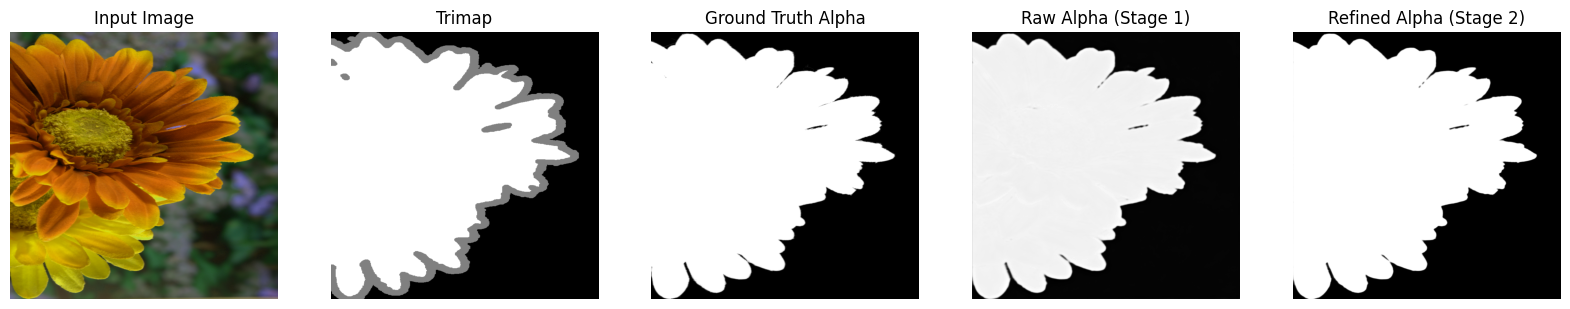

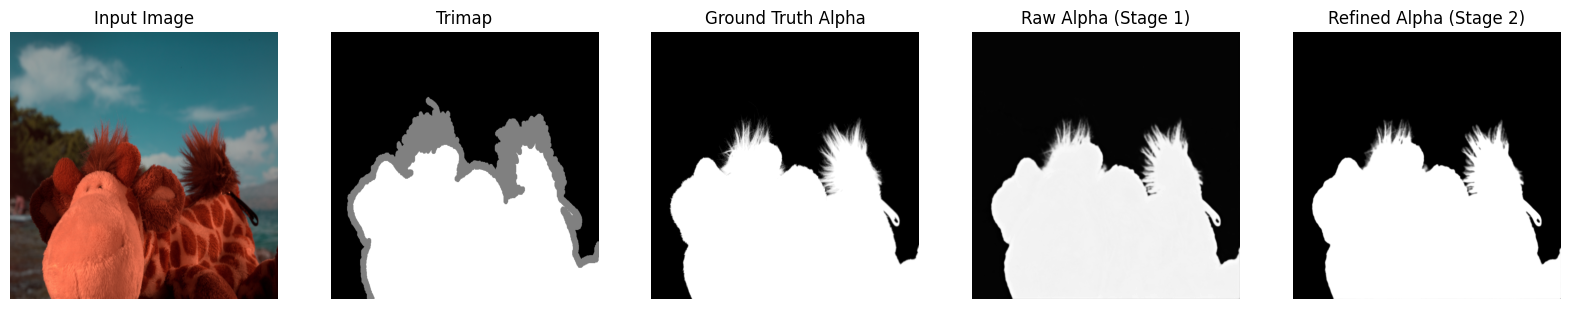

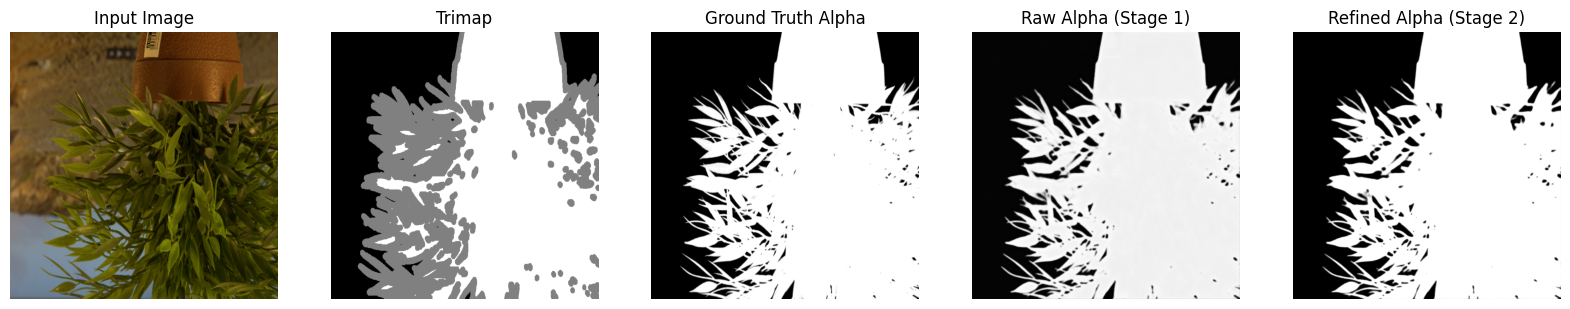

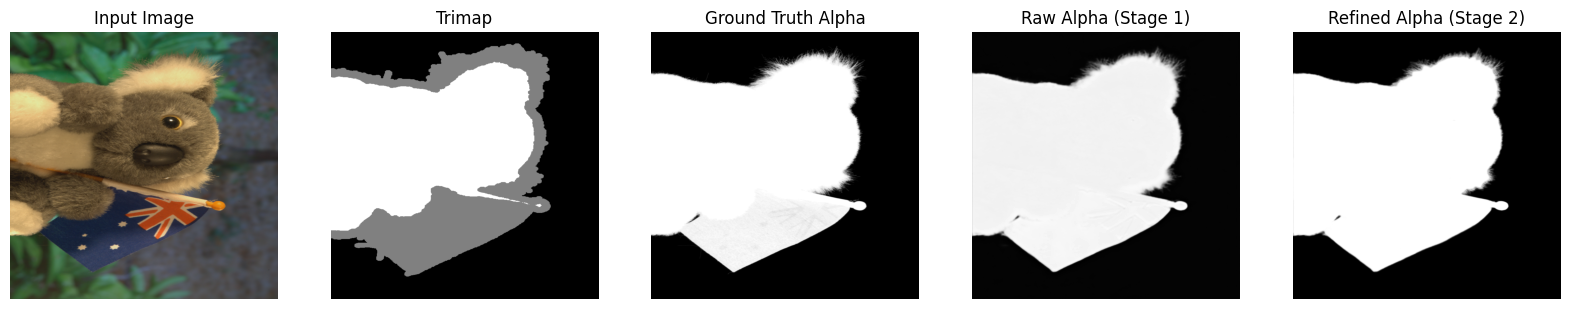

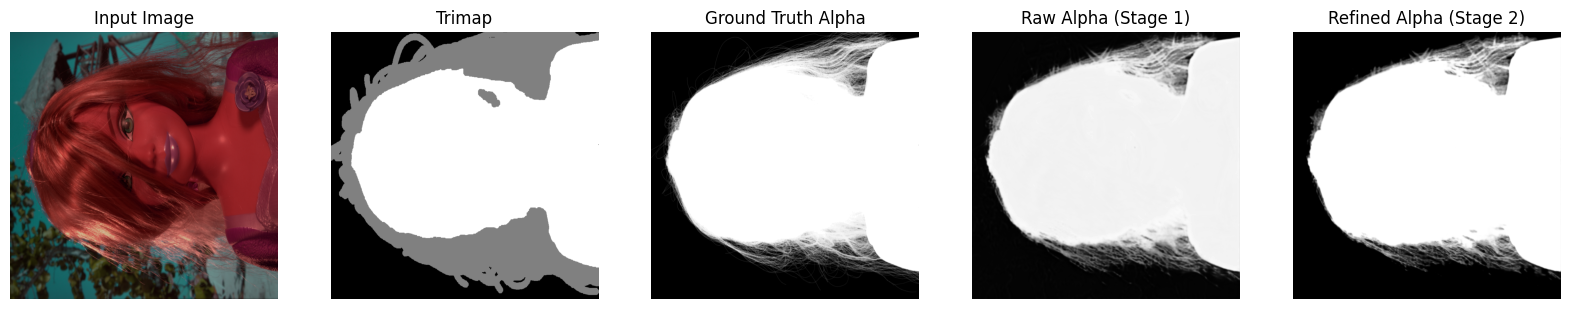

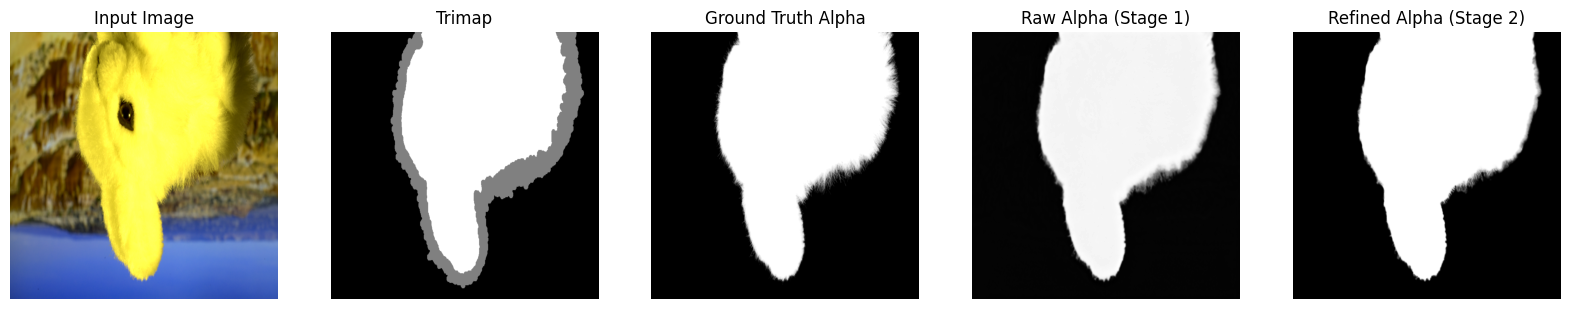

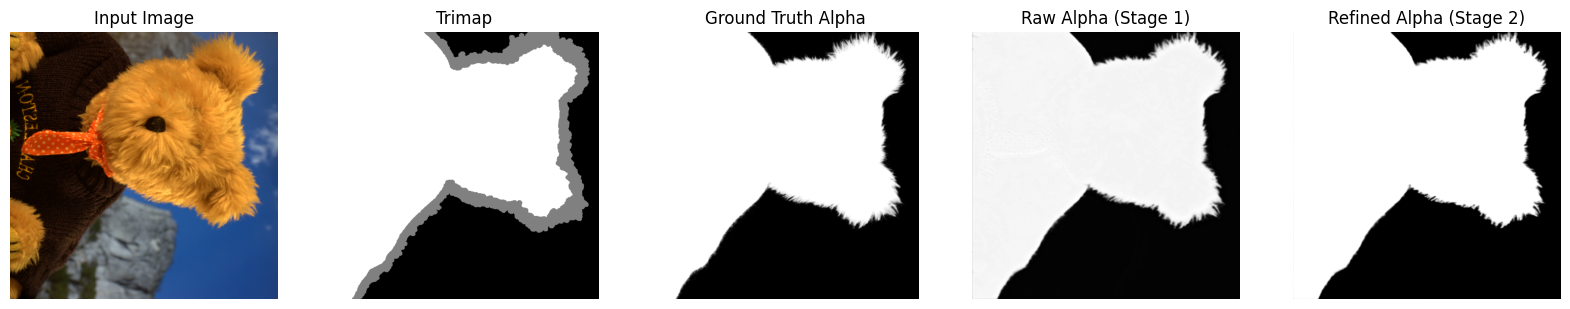

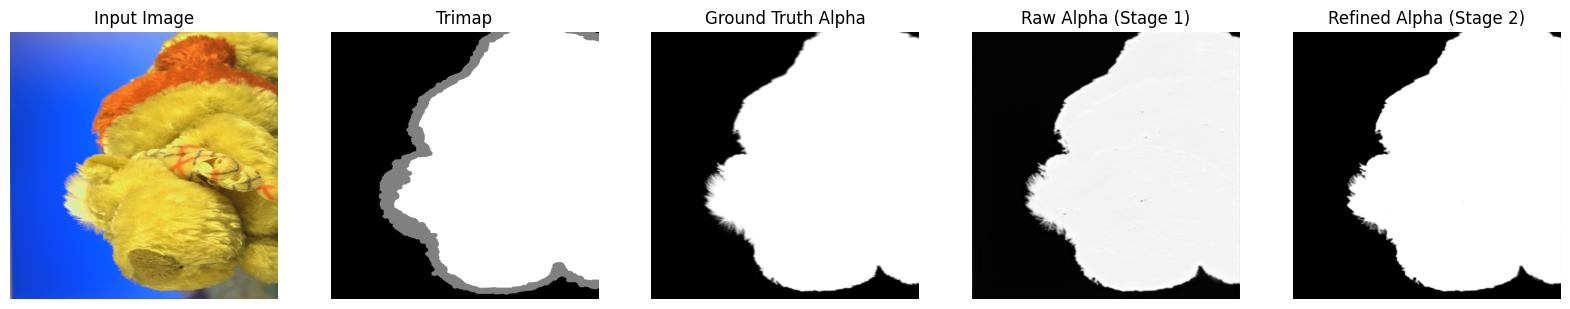

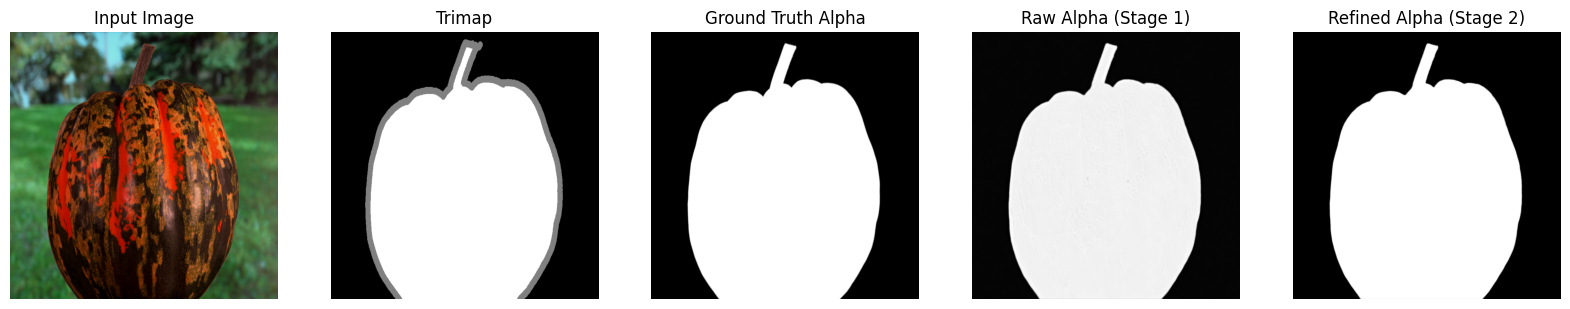

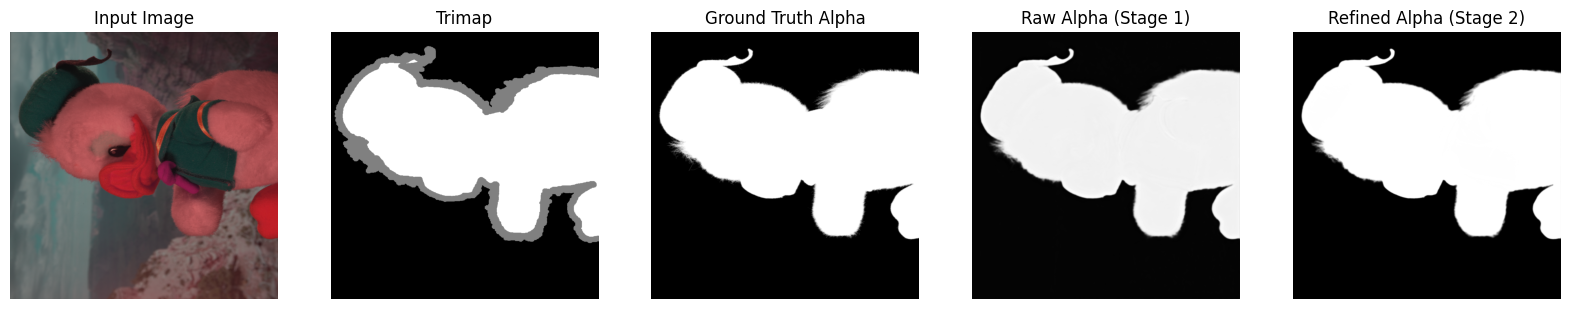

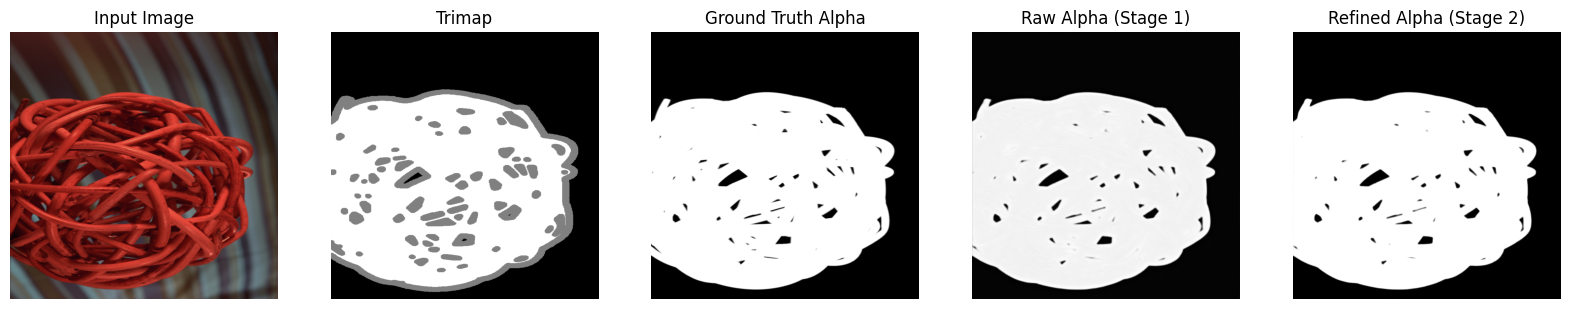

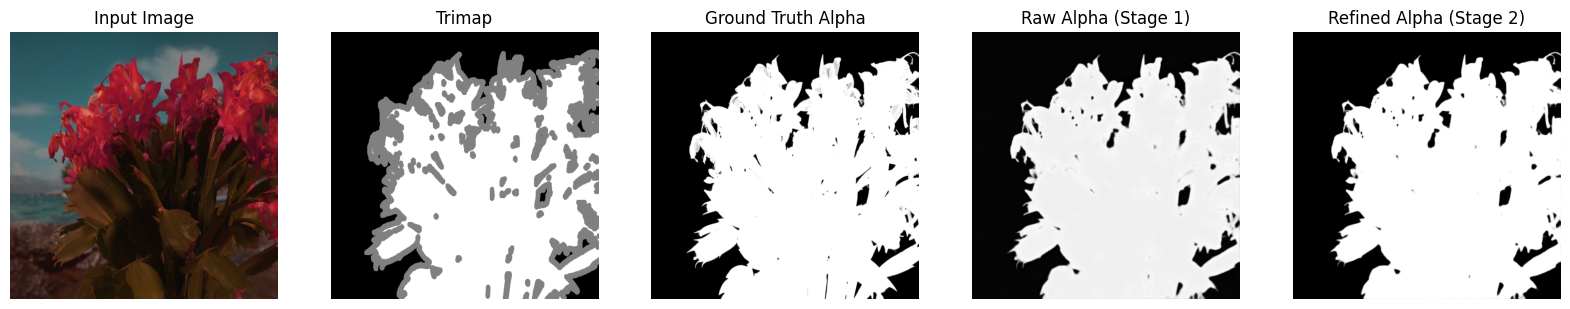

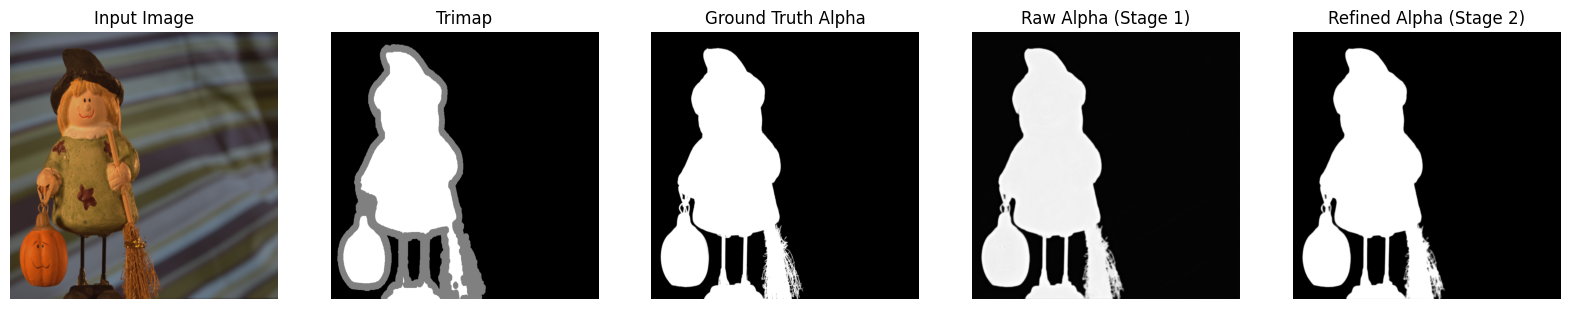

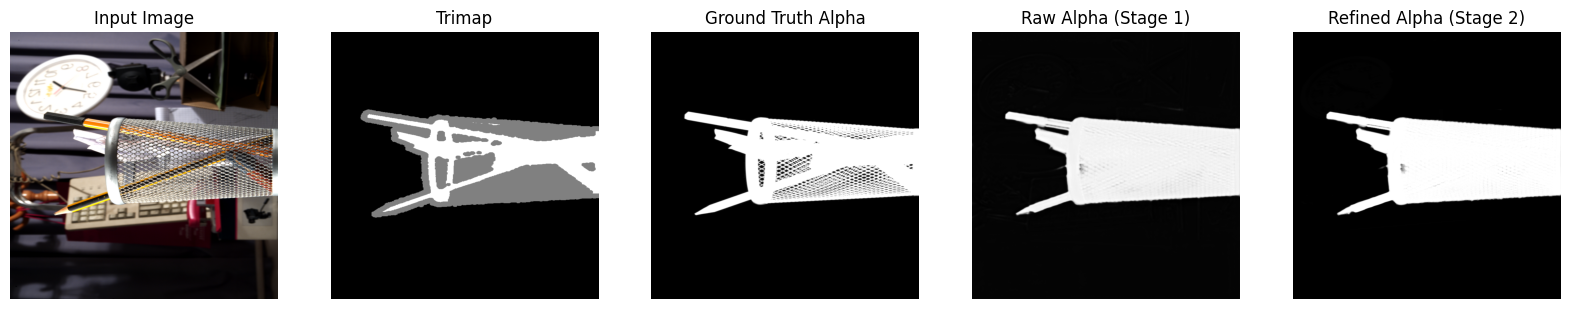

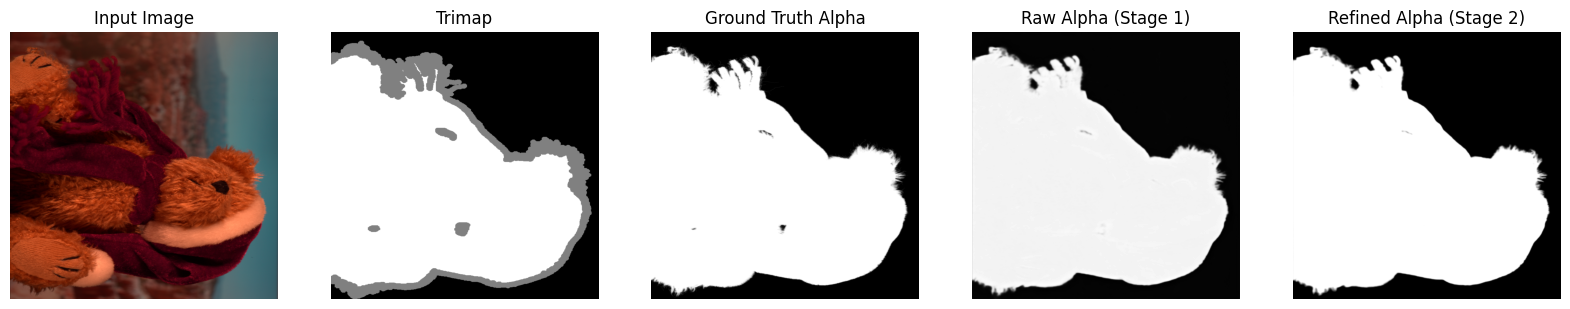

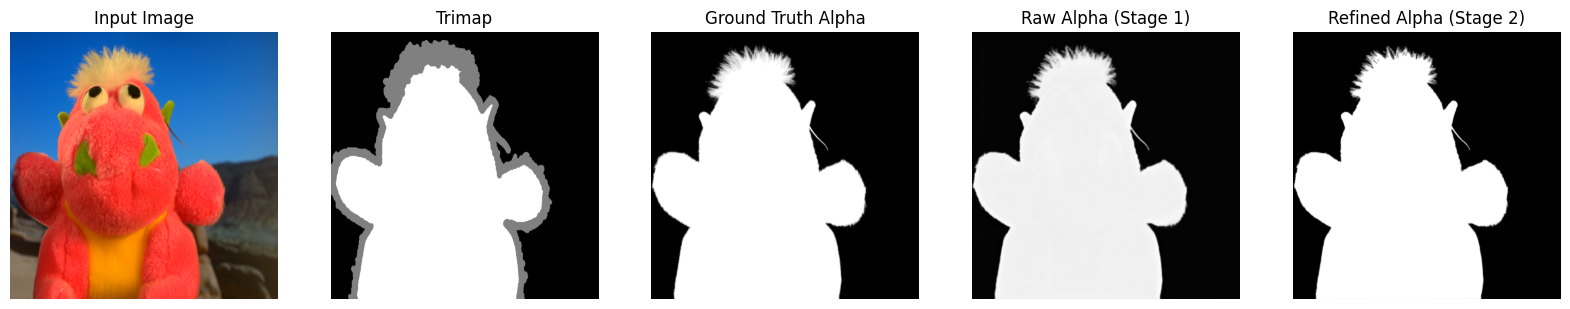

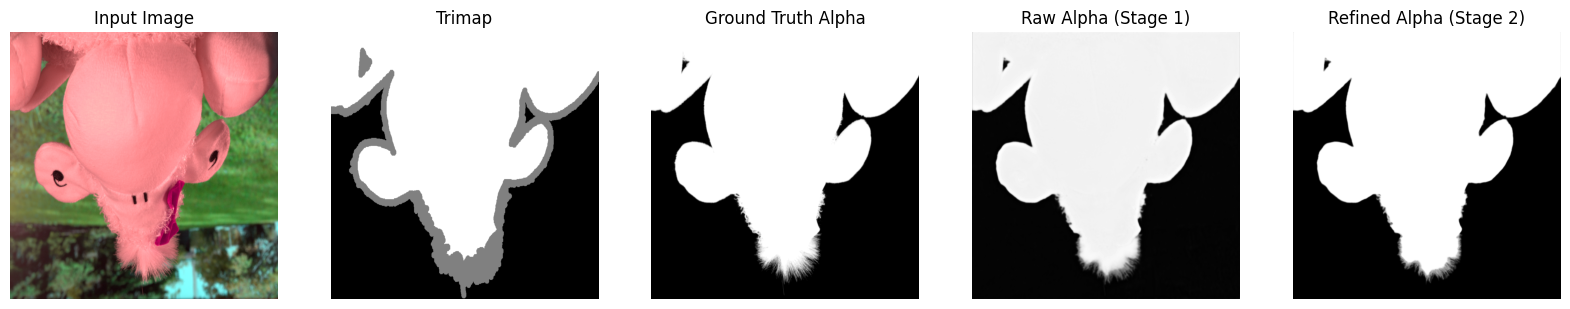

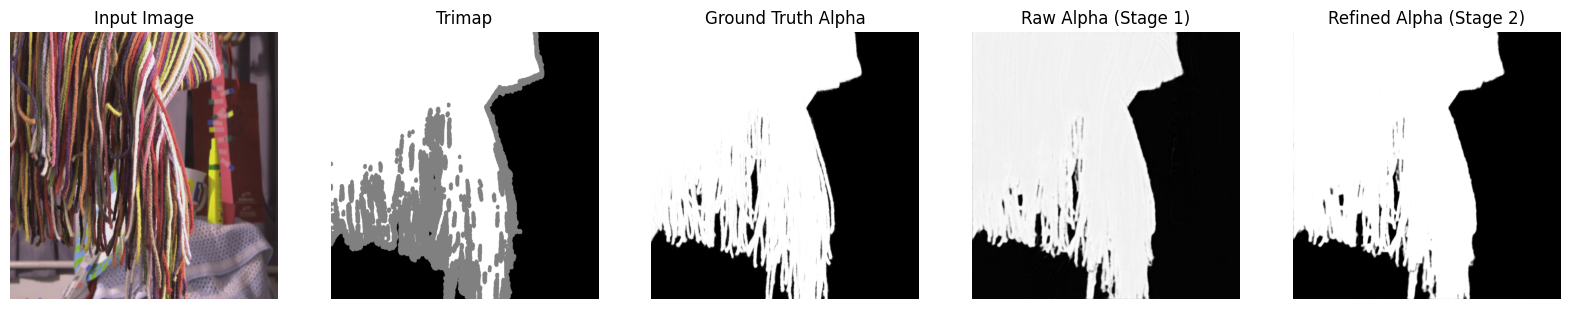

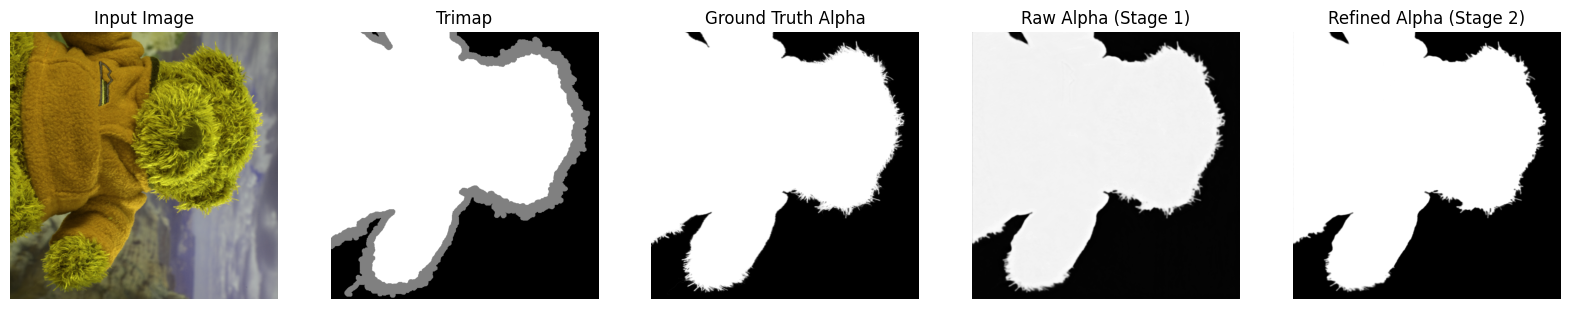

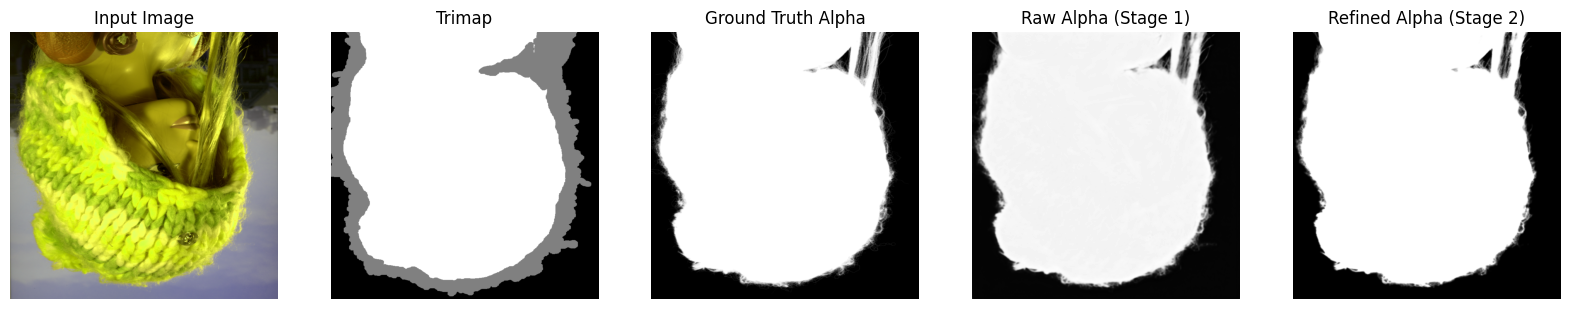

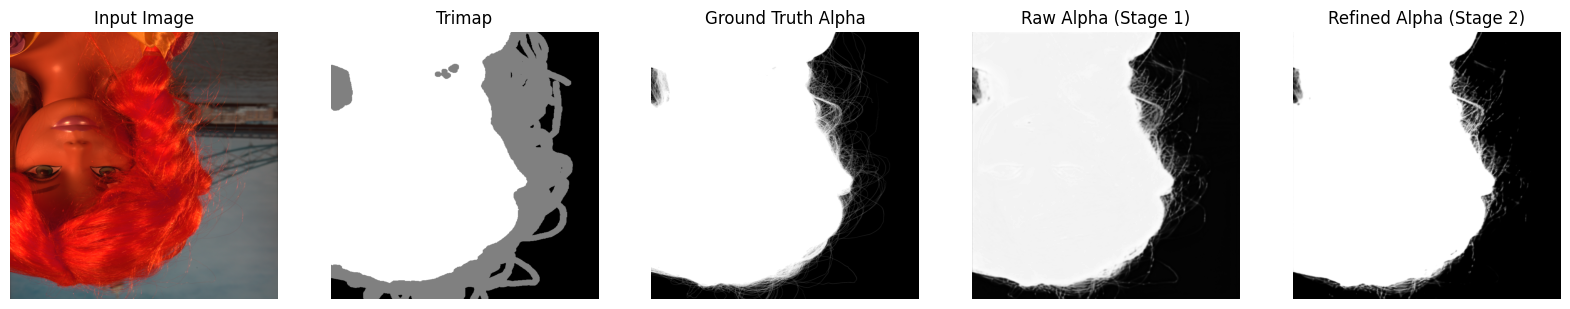

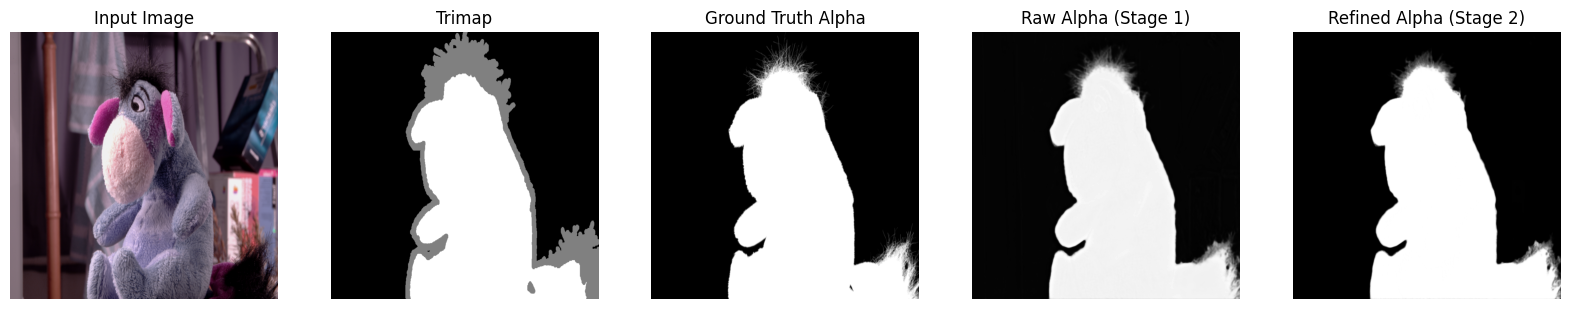

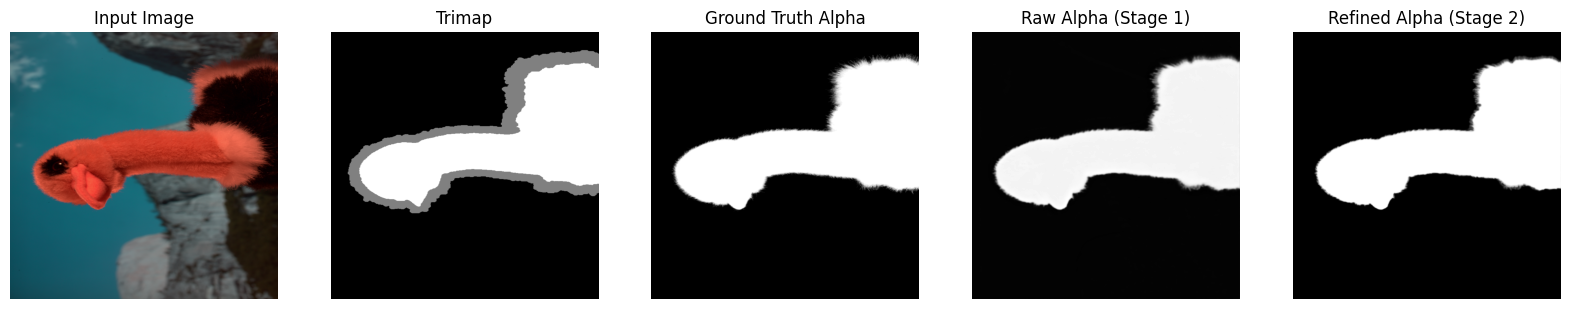

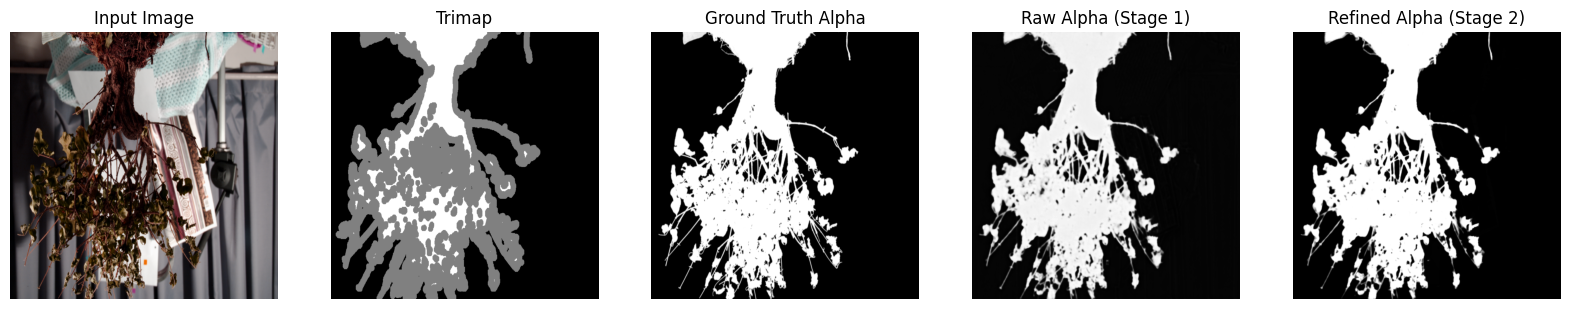

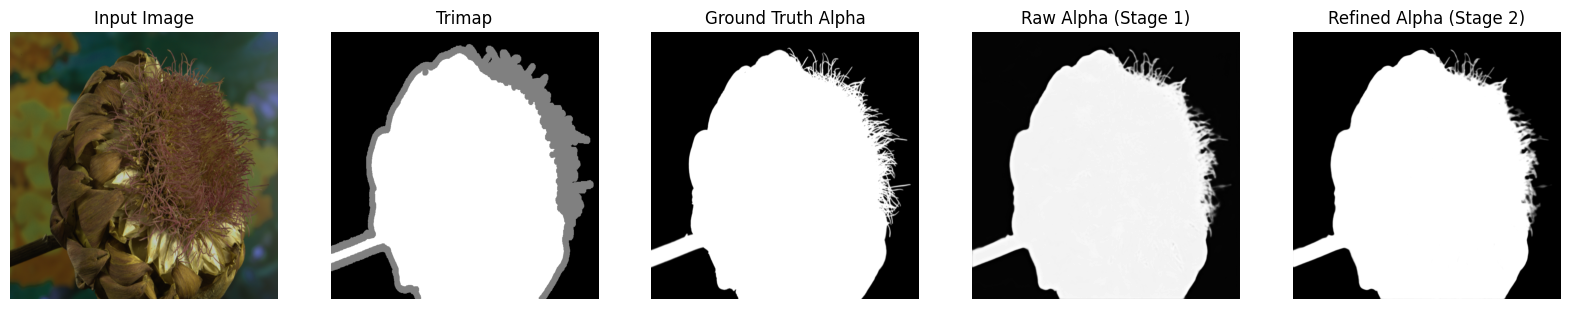

In [8]:
import matplotlib.pyplot as plt

def visualize_results(input_image, trimap, pred_alpha, gt_alpha):
    """
    Visualizes the input image, trimap, predicted alpha, and ground truth alpha.
    """
    input_image = input_image.permute(1, 2, 0).cpu().numpy()  # Convert to HWC format
    trimap = trimap.squeeze(0).cpu().numpy()  # Remove channel dimension
    pred_alpha = pred_alpha.squeeze(0).cpu().detach().numpy()  # Remove channel dimension
    gt_alpha = gt_alpha.squeeze(0).cpu().numpy()  # Remove channel dimension

    fig, ax = plt.subplots(1, 4, figsize=(16, 6))
    ax[0].imshow(input_image)
    ax[0].set_title("Input Image")
    ax[0].axis("off")

    ax[1].imshow(trimap, cmap="gray")
    ax[1].set_title("Trimap")
    ax[1].axis("off")

    ax[2].imshow(pred_alpha, cmap="gray")
    ax[2].set_title("Predicted Alpha")
    ax[2].axis("off")

    ax[3].imshow(gt_alpha, cmap="gray")
    ax[3].set_title("Ground Truth Alpha")
    ax[3].axis("off")

    plt.tight_layout()
    plt.show()

def visualize_results(model, dataloader, device, num_samples=5):
    model.eval()
    samples = 0
    with torch.no_grad():
        for batch in dataloader:
            input_image, trimap, gt_alpha = batch
            input_image = input_image.to(device)
            trimap = trimap.to(device)
            gt_alpha = gt_alpha.to(device)

            raw_alpha, refined_alpha = model(input_image, trimap)

            input_image_np = input_image.cpu().numpy()
            trimap_np = trimap.cpu().numpy()
            gt_alpha_np = gt_alpha.cpu().numpy()
            raw_alpha_np = raw_alpha.cpu().numpy()
            refined_alpha_np = refined_alpha.cpu().numpy()

            batch_size = input_image_np.shape[0]
            for i in range(batch_size):
                fig, axs = plt.subplots(1, 5, figsize=(20, 4))
                axs[0].imshow(np.transpose(input_image_np[i], (1, 2, 0)))
                axs[0].set_title("Input Image")
                axs[0].axis('off')

                axs[1].imshow(trimap_np[i][0], cmap='gray')
                axs[1].set_title("Trimap")
                axs[1].axis('off')

                axs[2].imshow(gt_alpha_np[i][0], cmap='gray')
                axs[2].set_title("Ground Truth Alpha")
                axs[2].axis('off')

                axs[3].imshow(raw_alpha_np[i][0], cmap='gray')
                axs[3].set_title("Raw Alpha (Stage 1)")
                axs[3].axis('off')

                axs[4].imshow(refined_alpha_np[i][0], cmap='gray')
                axs[4].set_title("Refined Alpha (Stage 2)")
                axs[4].axis('off')

                plt.show()

                samples += 1
                if samples >= num_samples:
                    return

# Example usage (uncomment to visualize after training):
visualize_results(model, data_loader, device, num_samples=25)
